# Semester Assignment INFO284  
**Candidates:** 213, 214, 111  

---

## Table of Contents  

### 1. Sentiment Analysis with Machine Learning - Task 1  

1.1 **Libraries**  

1.2 **Intro**  

1.3 **Data Visualization**  

1.4 **Sampling and Cleaning the Dataset**  
  1.4.1 Sampling the Dataset  
  1.4.2 Cleaning the Dataset  
  1.4.3 Preprocessing  

1.5 **Preparing the Testing and Training Data**  
  1.5.1 Preprocess for LSTM  
  1.5.2 Wordclouds of the Reviews  

1.6 **Making and Evaluating the Models**  
  1.6.1 Train and Test Split  
  1.6.2 TF-IDF Vectorizer  
  1.6.3 Naive Bayes  
  1.6.4 Logistic Regression  
  1.6.5 Linear Support Vector Machine  
  1.6.6 LSTM  
  1.6.7 Evaluating the LSTM  

1.7 **Sources**

---

### 2. CNN with Binary Classification - Task 2  

2.1 **Libraries**  

2.2 **Transformation and Analysis**  
  2.2.1 Loading the Data  
  2.2.2 What Data Are We Dealing With?  

2.3 **Making Our Model**  
  2.3.1 Specify Our Target Class  
  2.3.2 The Model We Are Using – ResNet18  
  2.3.3 Training-Loop  

2.4 **Evaluation**  
  2.4.1 Confusion Matrix  

2.5 **Testing with a Random Image**  

2.6 **Sources**

# Sentiment analysis with machine learning - Task 1

## Libraries

We import several libraries to simplify and streamline the process of data analysis and machine learning. The re library is used for cleaning text data with regular expressions, while numpy helps with numerical computations and array manipulations. pandas is essential for handling and analyzing structured data, and matplotlib is used to create visualizations that help us better understand the data. The sklearn library provides tools for machine learning, including model training and evaluation. For natural language processing tasks like tokenization and stopword removal, we use nltk, and wordcloud is used to generate word clouds to visualize the most frequent words in the dataset. The PIL library is used for image processing tasks like resizing images, while gensim helps with text processing, such as creating word embeddings. Finally, tensorflow and keras are used for building and training deep learning models like LSTMs.

In [2]:
# These have to be installed through running "pip install -r requirements.txt"

import re # for regular expressions
import numpy as np # for numerical computation
import pandas as pd # for data manipulation
import matplotlib.pyplot as plt # for plotting
import sklearn  # machine learning library
import nltk # natural language toolkit
import re # for regular expressions

from nltk.corpus import stopwords # to remove stopwords
from nltk.tokenize import word_tokenize # to tokenize
from nltk.stem import WordNetLemmatizer # to lemmatize
from nltk.sentiment.vader import SentimentIntensityAnalyzer # to analyze sentiment

from wordcloud import WordCloud # to visualize text
from PIL import Image # to load images

from gensim.test.utils import common_texts  # some example texts

from sklearn.feature_extraction.text import TfidfVectorizer # to convert text to numbers 
from sklearn.naive_bayes import MultinomialNB # to build a model
from sklearn.linear_model import LogisticRegression # to build a model
from sklearn.svm import LinearSVC # to build a model
from sklearn.model_selection import train_test_split # to split the data
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, mean_squared_error  # to evaluate the model
from sklearn.metrics import classification_report # to evaluate the model

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from keras.utils import pad_sequences
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import MinMaxScaler 

## Intro
 The objective of this project is to conduct sentiment analysis on a dataset of hotel reviews in order to predict a corresponding review score based on the textual content of each review. By leveraging natural language processing techniques, we aim to analyze the sentiments expressed in the reviews and establish a predictive model that can classify them as either negative or positive.

## Data Visualization
 In this first section we want to visualize the data to get a better understanding of the dataset. The dataset includes 17 columns, where each row is a hotel review. The columns include a person’s experience with a certain hotel, where they are from and the location of the hotel. 
 The data we want to focus on later in this analysis is the written review and the review score, however we include this data vizualisation section in order for you to get a better overview of the dataset.


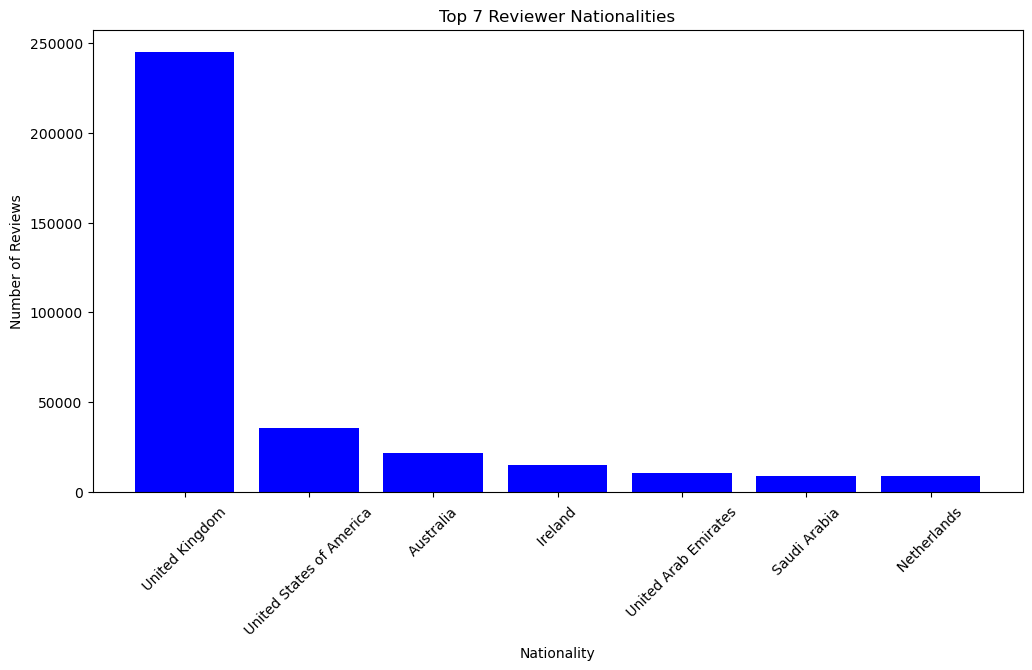

In [3]:
# Distrobution of nationality (top 7 nationalities)
df = pd.read_csv('Hotel_Reviews.csv')

top_nationalities = df['Reviewer_Nationality']. value_counts().head(7)

plt.figure(figsize=(12, 6))
plt.bar(top_nationalities.index, top_nationalities.values, color='blue')
plt.xticks(rotation=45)
plt.title("Top 7 Reviewer Nationalities")
plt.xlabel("Nationality")
plt.ylabel("Number of Reviews")
plt.show()

The majority of the reviewers are from English speaking countries. The dataset only includes English written reviews.

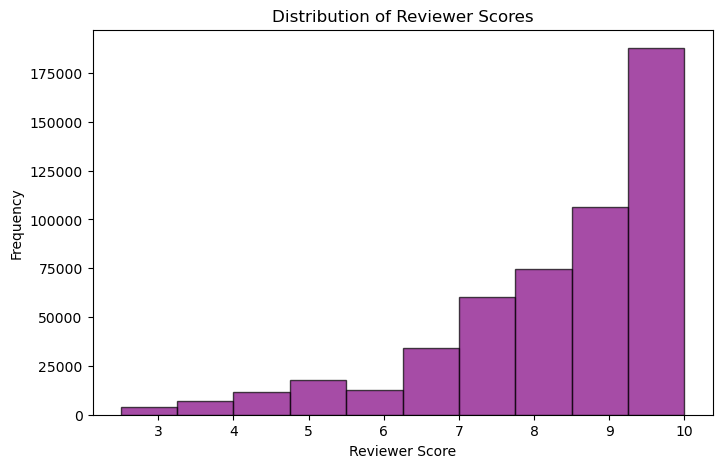

In [ ]:
plt.figure(figsize=(8, 5))

# Review Score Distribution
plt.hist(df['Reviewer_Score'], bins=10, color="purple", edgecolor="black", alpha=0.7)
plt.title("Distribution of Reviewer Scores")
plt.xlabel("Reviewer Score")
plt.ylabel("Frequency")
plt.show()

The majority of the review scores are positive. We will take this into concideration for when we later split the reviews to classify them as positive or negative. 

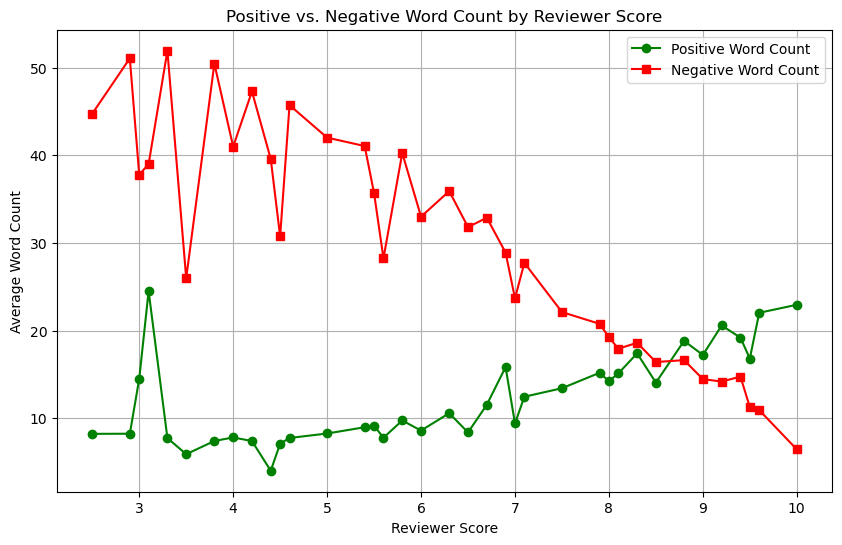

In [ ]:
review_score_grouped = df.groupby("Reviewer_Score")[
    ["Review_Total_Positive_Word_Counts", "Review_Total_Negative_Word_Counts"]
].mean()

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot both lines
ax.plot(review_score_grouped.index, review_score_grouped["Review_Total_Positive_Word_Counts"],
        marker="o", linestyle="-", color="green", label="Positive Word Count")

ax.plot(review_score_grouped.index, review_score_grouped["Review_Total_Negative_Word_Counts"],
        marker="s", linestyle="-", color="red", label="Negative Word Count")

# Labels and title
ax.set_xlabel("Reviewer Score")
ax.set_ylabel("Average Word Count")
ax.set_title("Positive vs. Negative Word Count by Reviewer Score")
ax.legend()
ax.grid(True)

# Show plot
plt.show()

This graph shows the average word could for each review score. This graph is important because it tells us how many positive/negative words are in a review based on the reviewer score. The two graphs intersect at around 8.5, which is the number we use to separate negative reviews from positive reviews. 

## Sampling and Cleaning the Dataset
### Sampling the Dataset
- We sample 221764 reviews from each group to create a balanced dataset. We chose this specific amount becuase it is the smallest class size after dividing the reviews based on our threshold of 8.5

- We use min_count as the sample size of both the positive and negative samples. Random_state is set to 42 which ensures reproducibility of the random sampling.

- We then concatenate the two samples and shuffle the rows, marking them as positive for reviews with scores larger than 8.5 and as negative for reviews with scores smaller then 8.5

In [ ]:
# Storing the csv file as a pandas dataframe and sample 50/50 of the positive and negative scores
# Separate reviews
positive_reviews = df[df['Reviewer_Score'] > 8.5]
negative_reviews = df[df['Reviewer_Score'] < 8.5]

# Find the smallest class size (negatives)
min_count = min(len(positive_reviews), len(negative_reviews))
print(f"Using {min_count} samples from each class for balance")

# Sample equal number from both
positive_sample = positive_reviews.sample(n=min_count, random_state=42)
negative_sample = negative_reviews.sample(n=min_count, random_state=42)

# Combine and shuffle
balanced_df = pd.concat([positive_sample, negative_sample])
df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Check the new balance
print(df['Reviewer_Score'].apply(lambda x: 'positive' if x > 8.5 else 'negative').value_counts())

Using 221764 samples from each class for balance
Reviewer_Score
positive    221764
negative    221764
Name: count, dtype: int64


### Cleaning the Dataset

We replace the ‘no positive’ and ‘no negative’ reviews with an empty space. This helps reduce noise before we begin the sentiment analysis.

In [ ]:
def replace(cell): 
    if cell == "No Positive" or cell == "No Negative":
        return ""
    return cell

df['Negative_Review'] = df['Negative_Review'].apply(replace)
df['Positive_Review'] = df["Positive_Review"].apply(replace)

We then combine the positive and negative reviews to make them into a singular row called ‘review’

In [ ]:
def combine_names(row):
    return f"{row['Positive_Review']} {row['Negative_Review']}"


df["Review"] = df.apply(combine_names, axis="columns")

The columns we want to focus on now is the reviewer_score and Review columns. The other columns are irrelevant because we want to predict the reviewer_score based on the review

In [ ]:
df = df.drop(["Hotel_Address", "Additional_Number_of_Scoring", "Review_Date", "Average_Score", "Reviewer_Nationality", "Review_Total_Negative_Word_Counts", "Review_Total_Positive_Word_Counts", "Total_Number_of_Reviews_Reviewer_Has_Given", "Tags", "days_since_review", "lat", "lng", "Hotel_Name", "Total_Number_of_Reviews", "Negative_Review", "Positive_Review"], axis = "columns")
df

,Reviewer_Score,Review
0,9.2,Amazing location and easy to get to anywhere ...
1,9.2,Very nice helpful young and dynamic staff and...
2,9.6,I like the design of building Nice high stand...
3,9.6,The old but elegant structure architecture of...
4,8.8,Really good location in terms of tubes statio...
...,...,...
443523,8.3,the room was a good size it was very clean th...
443524,7.5,Sink in bathroom too small couldn t wash tee...
443525,10.0,Amazing as always we always get a suite never...
443526,10.0,The hotel and staff were wonderful and made o...


### Preprocessing
Here, we preprocess the text by cleaning it up to further reduce noise. This will make the text better fitted for machine learning. The word lemmatizer converts words into their base form, making the analysis more efficient. 
- First, we make this whole string lowercase
- We then remove special characters and numbers by using regular expression. 
- Finally, we tokenize the words to turn the sentiments into a structured format that a model can interpret and join them into a singular string

In [ ]:
# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Define the preprocessing function
def preprocess_text(text):
    # 1. Lowercase
    text = text.lower()
    
    # 2. Remove special characters and numbers (keep only letters and spaces)
    text = re.sub(r'[^a-z\s]', '', text)
    
    # 3. Tokenize
    tokens = word_tokenize(text)
    
    # 4. Remove stopwords
    filtered_tokens = [token for token in tokens if token not in stopwords.words('english')]
    
    # 5. Lemmatize
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    
    # 6. Join back into a string
    processed_text = ' '.join(lemmatized_tokens)
    
    return processed_text

# Apply to your DataFrame
df['Review'] = df['Review'].apply(preprocess_text)

In [ ]:
# Add a column for y, which gives the review either positive or negative
df['posneg'] = df['Reviewer_Score'].apply(lambda x: 0 if x < 8.5 else 1)

## Preparing the Testing and Training Data
### Preprocess for LSTM
In this part, we preprocess the text for our LSTM-model that we are going to use later.

- First, we tokenize the text, converting it to a sequence of integers. We limit the vocabulary to the top 10,000 most frequent words and designate a token for the words that are not in the top 10,000
- We then use fit_on_texts to build the word index based on the reviews so that is learns the frequency of each word and assigns them an integer index.
- Then, we convert each review into a list of integers corresponding to word indices.
- Finally, we use padding and truncination to ensure that all input sequences have the same length, which is necessary for efficient batch processing in neural network models. The uniform length is set to max 50

In [ ]:
# Preprocess for LSTM

# Tokenizer setup
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['Review'])

# Convert reviews to sequences
sequences = tokenizer.texts_to_sequences(df['Review'])

# Pad sequences (adjust maxlen as needed)
maxlen = 50
padded = pad_sequences(sequences, padding='post', truncating='post', maxlen=maxlen)

We now wish to create a dedicated train-test split for the LSTM model we are using. This separate split is important because of how LSTMs operate: unlike models that rely on TF-IDF representations where word order is ignored, LSTMs process sequences of words in their original order. This allows the model to capture contextual information, such as in the difference between "good" and "not good", where the presence of "not" before "good" completely changes the sentiment. To preserve this sequential information and ensure that the model learns effectively, we construct a specific split suited to the needs of the LSTM.

In [ ]:
X_LSTM = padded
y_LSTM = df['posneg']

X_train_LSTM, X_test_LSTM, y_train_LSTM, y_test_LSTM = train_test_split(
    padded, df['posneg'], test_size=0.25, random_state=42
)

Next, we prepare the training data by classifying the reviews into positive and negative categories. Positive reviews are labelled with a 1, while negative reviews are labelled with a 0. After assigning these labels, we define separate variables to hold the positive and negative training datasets, each containing the corresponding review text.

In [ ]:
# Calculate Positive and Negative Reviews
train_pos = df[ df['posneg'] == 1]
train_pos = train_pos['Review']
train_neg = df[ df['posneg'] == 0]
train_neg = train_neg['Review']

### Wordclouds of the Reviews
Using the WordCloud library we define a function that generates word clouds from the pre-processed text, allowing us to visually explore the most frequent words from the reviews. To enhance the quality of the word cloud, we also implemented a function to remove some common ‘neutral’ words from the reviews to reduce noise and to ensure that the most relevant words are highlighted.

In [ ]:
# Generate WordCloud function for negative and positive reviews

def wordCloud_generator(data, color, color_map):

    
    wordcloud = WordCloud(width = 1000, height = 1000,
                          background_color =color,
                          min_font_size = 12,
                          colormap= color_map,
                         ).generate(' '.join(data.values))
    
    # plot the WordCloud image                        
    plt.figure(figsize = (7, 10), facecolor = None) 
    plt.imshow(wordcloud, interpolation='bilinear') 
    plt.axis('off')
    
    plt.show() 

Here, we remove words that are not relevant to the sentiment of the text. For example, words like "hotel" are neither clearly positive nor negative, and are often used so frequently that they don’t provide meaningful information for classification.

In [ ]:
# We remove unrelated words that are used alot

def remove_unwaned_words(text, words_to_remove):
    return text.apply(lambda text: " ".join(word for word in text.split() if word.lower() not in words_to_remove))

unwanted_words = {'hotel', 'room', 'staff', 'bathroom', 'breakfast', 'location'}

train_pos = remove_unwaned_words(train_pos, unwanted_words)
train_neg = remove_unwaned_words(train_neg, unwanted_words)

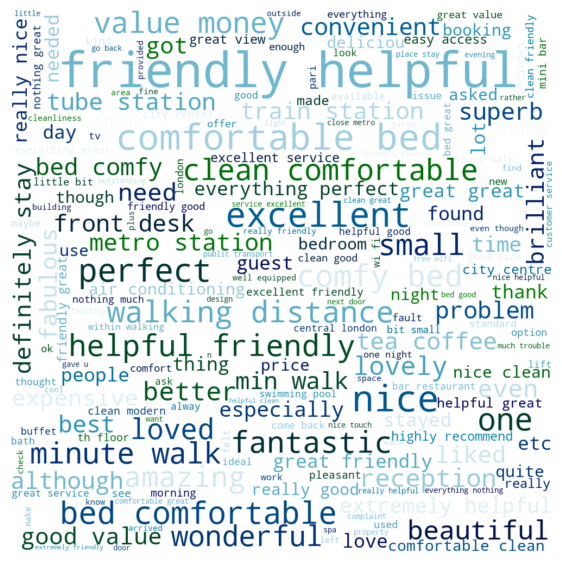

In [ ]:
# WordCloud for Positive Review

wordCloud_generator(train_pos, 'white', 'ocean')

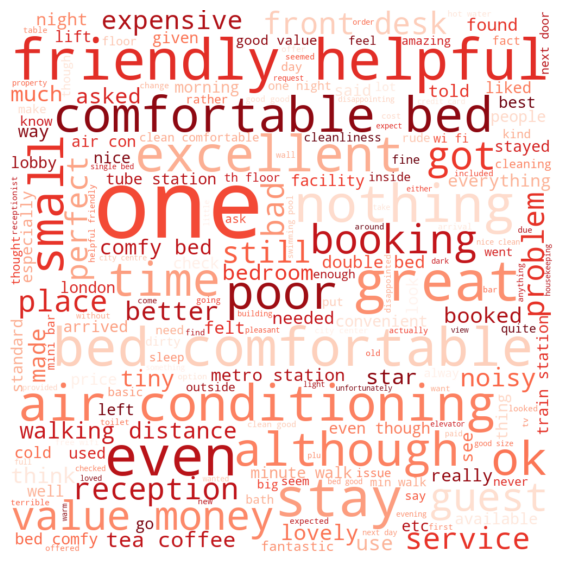

In [ ]:
# WordCloud for Negative Review

wordCloud_generator(train_neg, 'white', 'Reds')

The data is now ready to be split into training and testing data. We use 25% of the data for testing, while the remaining 75% will be used for training. 

## Making the Models

### Train and test split

In [ ]:
x = df[['Review']] 
y = df['posneg']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

### TF-IDF Vectorizer

We use a text vectorization technique called TF-IDF to transform the text data into a format that machine learning algorithms can understand. This technique gives a score to each word that reflects how important it is in relation to the entire dataset. It does this by reducing the influence of common, less meaningful words. This enables the models to focus on the most important words for the sentiment prediction. 

For the parameters: we set min_df to 10, meaning that it ignores words that appear in fewer than 10 rows (eliminates rare and uninformative terms). Max_df is set to 0.9, this ignores words that appear in more than 90% of the documents (often common or overly generic)

We use fit_tranform on the training data and only transform on the test data. This is because we don’t want to learn new vocabulary or IDF scores from the test data. This would cause data leakage. 


In [ ]:
# Initialize the TfidfVectorizer
tfidf = TfidfVectorizer(min_df=10, max_df=0.9, stop_words='english')

# Fit on training data only
tfidf_train = tfidf.fit_transform(X_train['Review'])

# Transform test data
tfidf_test = tfidf.transform(X_test['Review'])

print("Our x_train data ready to be used in the model")
print(X_train['Review'].head(10))
print("Our y_train data ready to be used in the model")
print(y_train.head(10))

X_train = tfidf_train
X_test = tfidf_test


Our x_train data ready to be used in the model
146753    asked pay hour early check room available rece...
73666                                           open window
290660                                           everything
43899     room really clean well maintained shower fanta...
1124      comfortable bed room good condition quality fu...
85396     one best hotel uk staff attentive extremely sm...
33546     really comfy bed lovely bathroom esp shower ea...
109651    staff absolutely lovely reception dining staff...
31021     staff lovely breakfast good service excellent ...
93294     bed comfortable smoking room accommodated per ...
Name: Review, dtype: object
Our y_train data ready to be used in the model
146753    0
73666     0
290660    0
43899     0
1124      0
85396     1
33546     1
109651    1
31021     1
93294     0
Name: posneg, dtype: int64


### Naive Bayes

Naive Bayes is a fitting method for sentiment classification because many of the words in reviews carry strong sentiment signals, which can be learned easily from labeled data. When combined with TF-IDF, the model makes more accurate predictions because it benefits from the ability to focus on the most informative and distinct words.

In [ ]:
# Naive Bayes
nbmodel = MultinomialNB()
nbmodel.fit(X_train, y_train)
pred_nb = nbmodel.predict(X_test)

print("Naive Bayes")
print(classification_report(y_test, pred_nb))

Naive Bayes
              precision    recall  f1-score   support

           0       0.76      0.72      0.74     55472
           1       0.73      0.77      0.75     55410

    accuracy                           0.74    110882
   macro avg       0.75      0.74      0.74    110882
weighted avg       0.75      0.74      0.74    110882



### Logistic Regression

 After applying TF-IDF on the training- and test data, they end up becoming very sparse and high-dimensional. Logistic regression is a model that handels this type of data very efficiently. It can process large numbers of features, even when many of them are zero, without requiring a large amount of memory or computation. 

In [ ]:
# Logistic Regression
lrmodel = LogisticRegression(random_state=42, max_iter=300)
lrmodel.fit(X_train, y_train)
pred_lr = lrmodel.predict(X_test)

print("Logistic Regression")
print(classification_report(y_test, pred_lr))

Logistic Regression
              precision    recall  f1-score   support

           0       0.76      0.76      0.76     55472
           1       0.76      0.76      0.76     55410

    accuracy                           0.76    110882
   macro avg       0.76      0.76      0.76    110882
weighted avg       0.76      0.76      0.76    110882



### Linear Support Vector Machine

Linear SVC is also good at handeling sparse and high-dimensional data. This is becuase it aims  to maximize the margin between classes by focusing on the support vectors. By doing so, it prioritizes the distance from the decision boundary rather than individual points, which makes it less sensitive to outliers.

We concidered using the random forest model, but ultimently decided againt it as it is not as effective as the other models at handeling sparse features. Random forest is also prone to overfitting and would be to computationally expensive for this large dataset. 

In [ ]:
# Linear SVC
svmmodel = LinearSVC(random_state=42)
svmmodel.fit(X_train, y_train)
pred_svm = svmmodel.predict(X_test)

print("Support Vector Machine (LinearSVC)")
print(classification_report(y_test, pred_svm))

Support Vector Machine (LinearSVC)
              precision    recall  f1-score   support

           0       0.76      0.75      0.76     55472
           1       0.76      0.76      0.76     55410

    accuracy                           0.76    110882
   macro avg       0.76      0.76      0.76    110882
weighted avg       0.76      0.76      0.76    110882



### LSTM Model

Here we build the LSTM model. We start off with embedding. Input_dim represents the size of the vocabulary. Output_dim represents the size of the embedding space for each word. Input_length specifies the length of input sequences. In other words the number of words in each sentence.

When we define the LSTM we also make it a bidirectional LSTM. This means that the model processes the input sequences in both directions. This increases the performance of the model significantly.

We use dropout to prevent overfitting. What the dropout does is randomly discarding some of the information that is passed through. 

In [ ]:
# Build the LSTM model

model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=maxlen),
    Bidirectional(LSTM(64)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # For binary classification
])

Here we compile the model starting with loss. The loss function measures how well the models's prediction the true labels. Here we use binary crossentropy, which is commonly used when you have two possible classes.

The optimizer controls how the model's weights are updates during training. Adam is often used for its efficiency. 

The metrics are used to evaluate the modelss performance. Here we use accuracy, which shows the proportion of correct predictions. Precision is the ratio of true positive predictions to all positive predictions in the model. Recall is the ratio of true positive to all actual positives. AUC (Area Under the Curve) shows the models ability to distinguish classes, in this case positive and negative. The higher the AUC, the better the model is at this. 

In [ ]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=[
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall'),
        AUC(name='auc')
    ]
)

Here, we use the fit function to train the model. We specify 5 epochs, which means the model will pass through the entire dataset 5 times during training. The choice of 5 epochs helps balance the model’s learning process with the need for faster execution, allowing the program to complete quicker while still learning useful patterns from the data.

In [ ]:
history = model.fit(
    X_train_LSTM, y_train_LSTM,
    epochs=5, batch_size=64, validation_split=0.2
)

Epoch 1/5
4159/4159 ━━━━━━━━━━━━━━━━━━━━ 149s 36ms/step - accuracy: 0.7363 - auc: 0.8156 - loss: 0.5199 - precision: 0.7391 - recall: 0.7255 - val_accuracy: 0.7686 - val_auc: 0.8554 - val_loss: 0.4722 - val_precision: 0.7490 - val_recall: 0.8064
Epoch 2/5
4159/4159 ━━━━━━━━━━━━━━━━━━━━ 149s 36ms/step - accuracy: 0.7793 - auc: 0.8646 - loss: 0.4588 - precision: 0.7796 - recall: 0.7788 - val_accuracy: 0.7668 - val_auc: 0.8536 - val_loss: 0.4868 - val_precision: 0.7854 - val_recall: 0.7328
Epoch 3/5
4159/4159 ━━━━━━━━━━━━━━━━━━━━ 154s 37ms/step - accuracy: 0.7902 - auc: 0.8773 - loss: 0.4379 - precision: 0.7889 - recall: 0.7917 - val_accuracy: 0.7697 - val_auc: 0.8551 - val_loss: 0.4747 - val_precision: 0.7730 - val_recall: 0.7620
Epoch 4/5
4159/4159 ━━━━━━━━━━━━━━━━━━━━ 151s 36ms/step - accuracy: 0.8020 - auc: 0.8895 - loss: 0.4165 - precision: 0.7992 - recall: 0.8057 - val_accuracy: 0.7663 - val_auc: 0.8503 - val_loss: 0.4819 - val_precision: 0.7726 - val_recall: 0.7532
Epoch 5/5
   3/4

### Evaluating the LSTM

Here we evaluate the model's performance with our test set. It will print out the performance of the model with all the metrics previously mentioned. 

In [ ]:
loss, acc, prec, rec, auc = model.evaluate(X_test_LSTM, y_test_LSTM, verbose=1)
print(f"""Test metrics:
  Accuracy:  {acc:.4f}
  Precision: {prec:.4f}
  Recall:    {rec:.4f}
  AUC:       {auc:.4f}
""")

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7134 - auc: 0.7804 - loss: 0.8023 - precision: 0.6946 - recall: 0.7962
Test metrics:
  Accuracy:  0.7047
  Precision: 0.6759
  Recall:    0.7997
  AUC:       0.7727



Here we will generate two graphs to visually evaluate the performance of the model.

The first graph will monitor the models performance with accuracy and validation accuracy.

The second graph visualizes the how the loss changes over epochs. A decreasing loss inidicates that the model is learning well.

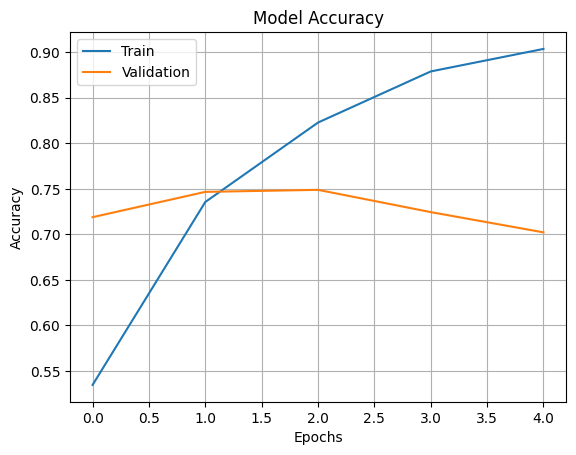

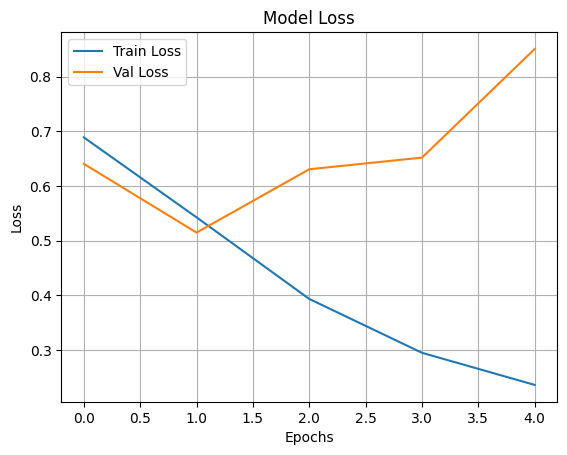

In [ ]:
# Accuracy plot
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Loss plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

## Sources
- 
- 
- 
- 

# CNN with binary classification - Task 2

## Libraries

Libraries are essential in simplifying the development process by providing pre-built functions and tools. They allow us to efficiently handle tasks like data manipulation, visualization, and building machine learning models without reinventing the wheel. In this project, we use libraries like PyTorch for deep learning, NumPy for numerical computations, and Matplotlib for visualizations.

In [ ]:
import torch # PyTorch
import torchvision # PyTorch Vision Library
import torchvision.datasets as datasets # Datasets
import torchvision.transforms as transforms # Transforms the dataset
import matplotlib.pyplot as plt # Plotting
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report # Vizualising the results
import numpy as np # Numerical computatons
from torchvision.utils import make_grid # Make a grid of images
from PIL import Image # Python Imaging Library
from torch.utils.data import DataLoader, Subset # Data Loader
import torchvision.models as models # Pretrained Models
import torch.nn as nn # Neural Network Module
import torch.optim as optim # Optimizer
from torchvision.models import resnet18, ResNet18_Weights # ResNet18, the model we will be using

# We were using Google Colab, so we needed to specify the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## Transformation and Analysis
Standardizing the dataset. Makes it easier to work with.

In [ ]:
transform = transforms.Compose([transforms.Resize((32, 32)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

### Loading the data
This code downloads the CIFAR-10 dataset and prepares it for training and evaluation. It loads the training data (50,000 images) and test data (10,000 images) while applying the specified image transformations, then creates DataLoaders to efficiently feed the data in mini-batches (with shuffling for training), and finally defines the class names for easy interpretation of the numerical labels.

In [ ]:
# Download and load training data
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load test data
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)



classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

### What Data are we Dealing With?
Showing how the data looks in the CIFAR-10 dataset. The output shows the images, with their labels.

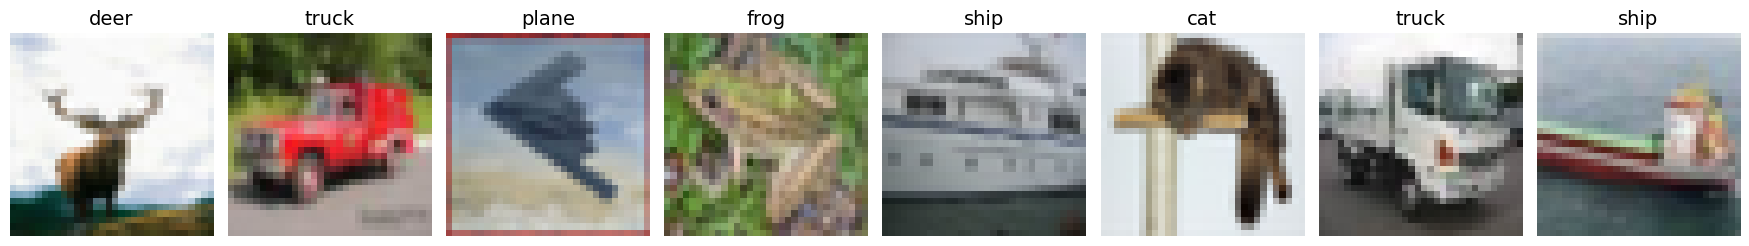

In [ ]:
def imshow_grid_with_labels(images, labels, classes, num_images=8):
    images = images[:num_images]
    images = images / 2 + 0.5  # unnormalize

    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 2.2, 3))

    for i in range(num_images):
        img = images[i].numpy().transpose((1, 2, 0))
        axes[i].imshow(img)
        axes[i].set_title(classes[labels[i]], fontsize=14)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

dataiter = iter(trainloader)
images, labels = next(dataiter)
imshow_grid_with_labels(images, labels, classes, num_images=8)

## Making our Model

### Specify our Target Class
This code converts the original 10-class CIFAR-10 labels into binary labels for a cat vs. not-cat classification task by assigning a label of 1 to “cat” (class 3) and 0 to all other classes. Then, it creates subsets covering the full training (40 000 images), testing (5000 images) and validation (5000) splits and builds DataLoaders that efficiently batch and, in the case of training, shuffle the data for model training and evaluation.

In [ ]:
target_class = 3  # 'cat'

# Convert CIFAR-10 dataset labels to binary: 1 = cat, 0 = not cat
def convert_to_binary(dataset, target_class=3):  # Default to 'cat' class (3)
    dataset.targets = [1 if label == target_class else 0 for label in dataset.targets]
    return dataset

# Apply conversion to binary classification for both train and test sets
trainset = convert_to_binary(trainset)
testset = convert_to_binary(testset)

# 40000 train, 5000 validation, 5000 test
train_subset = Subset(trainset, range(40000)) # Indices 0 to 39999 for training
valid_subset = Subset(trainset, range(40000, 45000))  # Indices 40000 to 44999 for validation
test_subset  = Subset(testset, range(5000))   # First 5000 images from test set for testing

# DataLoaders
trainLoader = torch.utils.data.DataLoader(train_subset, batch_size=64, shuffle=True, num_workers=2)
validLoader = torch.utils.data.DataLoader(valid_subset, batch_size=64, shuffle=False, num_workers=2)
testloader  = torch.utils.data.DataLoader(test_subset, batch_size=64, shuffle=False, num_workers=2)

### The Model we are Using - ResNet18
We use ResNet because it’s a powerful, well-established deep convolutional neural network architecture that leverages residual (skip) connections. These connections allow very deep networks to be trained effectively by helping gradients flow backward through many layers. Additionally, ResNet models (like ResNet18) are widely pre-trained on large datasets like ImageNet, which enables effective transfer learning—meaning we can fine-tune the network for our specific task (in this case, binary classification of cat vs. not-cat)

In [ ]:
# Load the ResNet18 model
weights = ResNet18_Weights.DEFAULT
model = resnet18(weights=weights)
model.fc = nn.Linear(model.fc.in_features, 1)
model = model.to(device)

### Training-Loop
This snippet sets up and runs a training loop for our binary classifier. We use the BCEWithLogitsLoss (which combines sigmoid activation and binary cross-entropy loss) along with the Adam optimizer. For each epoch, the code:
- Moves the images and labels to the device (CPU/GPU),
- Performs a forward pass through the model,
- Computes the loss,
- Backpropagates the gradients,
- Updates the model parameters.

We do this to iteratively minimize the loss so that our model learns to correctly classify images as “cat” (1) or “not cat” (0).

To run it, we were using a M3 Mac´s GPU, we then swapped to Google Colab (cuda) and could run much faster with more epochs.

In [ ]:
# Loss function and optimizer
# Calculate pos_weight as the ratio of negatives to positives in the training set
# Adam optimizer with weight decay to prevent overfitting
pos_weight = torch.tensor([9.0], device=device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

num_epochs = 5

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    for images, labels in trainLoader:
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(trainLoader)

    # Validation phase
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, labels in validLoader:
            images = images.to(device)
            labels = labels.float().unsqueeze(1).to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

    val_loss = running_val_loss / len(validLoader)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

Epoch 1, Train Loss: 0.8410, Validation Loss: 0.7444
Epoch 2, Train Loss: 0.6633, Validation Loss: 0.7142
Epoch 3, Train Loss: 0.6975, Validation Loss: 0.6931
Epoch 4, Train Loss: 0.5733, Validation Loss: 0.6520
Epoch 5, Train Loss: 0.5125, Validation Loss: 0.6407


We struggled a lot with the model overfitting, wich is why we added validation loss to the training loop, to indentify just how many epochs we could use before overfitting. The "pos_weight" helped a lot with reducing the amount of false negatives, effectively bettering our recall score. What it does is punishing the model for classifying a 'cat' as 'not cat'. These are common problems with imbalanced datasets where we are looking for a minority class.

The validation loss indicates if the model is startig to overfit (if it spikes and doesn´t recover). This is why we are using 5 epochs and not more, since the model started overfitting in epoch 6-7. This way we are getting optimal results.

## Evaluation
This snippet evaluates the model’s performance on the test data. It does the following:

- Sets the model to evaluation mode and disables gradient calculations (for efficiency).

- Iterates through the test dataset, moving images and labels to the correct device.

- Computes the model’s output, applies the sigmoid function to convert logits to probabilities, and thresholds at 0.5 to get  binary predictions.

- Compares predictions with the true labels and calculates measurements.

We do this to measure how well the trained model generalizes to unseen data without affecting its parameters.

In [ ]:
# Get balanced indices (first n of each class)
cat_idx = [i for i, label in enumerate(testset.targets) if label == 1]
not_cat_idx = [i for i, label in enumerate(testset.targets) if label == 0]
n = min(len(cat_idx), len(not_cat_idx))
balanced_indices = cat_idx[:n] + not_cat_idx[:n]

# Create a DataLoader for the balanced test set
balanced_testloader = torch.utils.data.DataLoader(
    Subset(testset, balanced_indices), batch_size=64, shuffle=False, num_workers=2
)

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in balanced_testloader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        preds = (torch.sigmoid(outputs) > 0.5).long().squeeze()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Print classification report
print(classification_report(all_labels, all_preds, target_names=['not cat', 'cat']))

              precision    recall  f1-score   support

     not cat       0.83      0.82      0.83      1000
         cat       0.83      0.84      0.83      1000

    accuracy                           0.83      2000
   macro avg       0.83      0.83      0.83      2000
weighted avg       0.83      0.83      0.83      2000



### Confusion Matrix
This illustrates how often the model predicts correctly, and shows when the model predicts wrongly.
The Matrix illustrates that the model mostly predicts correct.

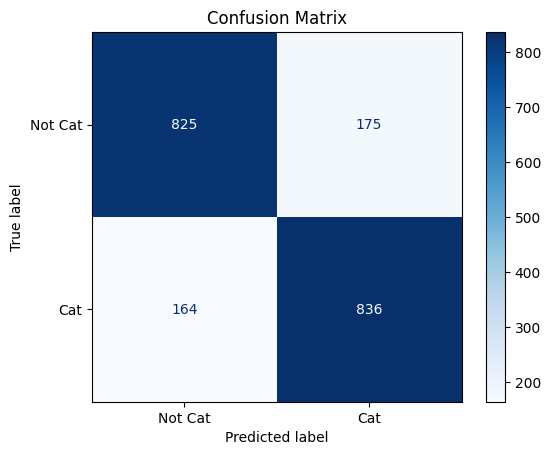

In [ ]:
# Collect predictions and true labels
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in balanced_testloader:
        images = images.to(device)
        outputs = model(images)
        preds = (torch.sigmoid(outputs) > 0.5).long().cpu().numpy()
        all_preds.extend(preds.flatten())
        all_labels.extend(labels.cpu().numpy())

# Compute and display confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Cat', 'Cat'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

## Testing with a Random Image
We found two random images of a cat and a dog on Google, and then resized them to fit CIFAR-10´s format we used for training (32x32).
We chose dog as the category we wanted to compare with, since it was the most similar class to cat. As you can see by the pictures below, our model correctly predicts if an image is of a cat or a dog. We used the same threshold as with the evaluation at 0.5

Prediction: Cat (confidence: 0.84)


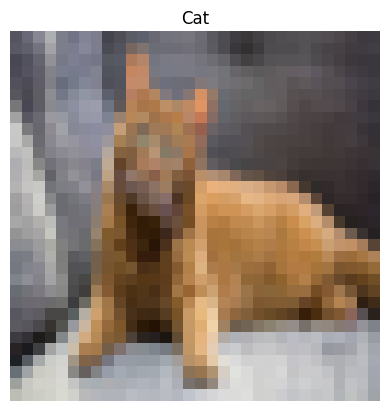

Prediction: Not Cat (confidence: 0.18)


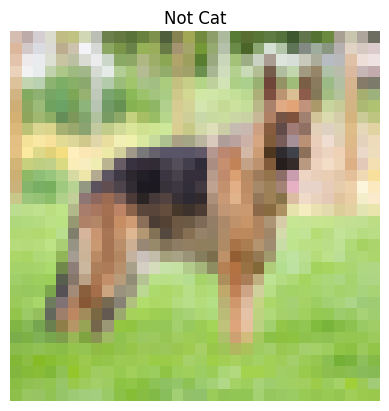

In [ ]:
# Make sure we have the right transformations for prediction
predict_transform = transforms.Compose([
    transforms.Resize((32, 32)),  # Match CIFAR-10 image size
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Match training normalization
])

def predict_image(img_path, model):
    model.eval()  # Set model to evaluation mode
    img = Image.open(img_path).convert('RGB')  # Open image
    img_tensor = predict_transform(img).unsqueeze(0).to(device)  # Apply transformations and move to device

    with torch.no_grad():
        output = model(img_tensor)  # Pass img_tensor to the model
        prob = torch.sigmoid(output).item()  # Apply sigmoid to get probability

    # Threshold for binary classification: 0.5 for cat vs not-cat
    result = "Cat" if prob > 0.5 else "Not Cat"
    print(f"Prediction: {result} (confidence: {prob:.2f})")

    # Show image with result title
    plt.imshow(img.resize((32, 32)))  # Resize to show what the model sees
    plt.title(result)
    plt.axis('off')
    plt.show()

# Finally, run:
predict_image("cat_image.jpg", model)
predict_image("dog_image.jpg", model)

## Sources
- 
- 
- 
- 
- 